# Report 

In [63]:
import ConfigParser
from my_suite_helpers.pdf_reader import read_to_clean
from my_suite_helpers.utils import dataset_genreator, precision, recall, f_measure
from my_suite_helpers.ATE_method import tf
from my_suite_helpers.term_grouping import term_grouping, jaro_sim
from my_suite_helpers.thd import thd
import timeit
import json
import ate
from os import listdir
import pandas as pd
import numpy as np

# GLOBAL
pdf_folder = "data/time"
txt_folder = "data/txt"
clean_txt_folder = "data/clean_txt"
golden_st_path = "hands-on/D22.txt"

In [64]:
reference_file_time = "hands-on/time-onto-paper/MyTimeOnto-Paper-manually-extracted-terms.csv"
terms_gs_df_time = pd.DataFrame.from_csv(reference_file_time, sep=';')
term_gs_agg_time= terms_gs_df_time.groupby(['term'])['num'].agg([np.sum])

terms_gs_df = pd.DataFrame.from_csv(golden_st_path, sep=';')
term_gs_agg = terms_gs_df.groupby(['term'])['num'].agg([np.sum])

orders = ['chrono', 'rev-chrono', 'bi-dir', 'random']
order = 'chrono'
num_input = len([f for f in listdir(clean_txt_folder)])
compare_to_c_value = True # c-value is very slow, so I disabled comparing

config = ConfigParser.ConfigParser()
config.readfp(open('config.ini'))
min_term_length = int(config.get('main', 'min_term_length'))
min_term_words = int(config.get('main', 'min_term_words'))
stopwords = json.loads(config.get('main', 'stopwords'))
term_patterns = json.loads(config.get('main', 'term_patterns'))

term_extractor = ate.TermExtractor(stopwords=stopwords, term_patterns=term_patterns, min_term_words=min_term_words,
                                   min_term_length=min_term_length)


C:\Users\kzorina\AppData\Local\Continuum\anaconda3\envs\python2.7\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  
C:\Users\kzorina\AppData\Local\Continuum\anaconda3\envs\python2.7\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """


## Stage 1. Reading from PDF and cleaning

For this stage I used ```read_to_clean``` function from ```my_suite_helpers.pdf_reader``` file

#### Input
PDF files from ```data/time```
#### Output
.txt files in ```data/clean_txt```

In [ ]:
start = timeit.default_timer()
read_to_clean(pdf_folder, clean_txt_folder)
stop = timeit.default_timer()
print("Elapsed time: {} s".format(stop-start))

All results are saved to clean_txt folder.
##### Elapsed time: 465 seconds

## Stage 2. Generating dataset

For this stage I used ```dataset_genreator``` function from ```my_suite_helpers.utils``` file

#### Input
order (acceptable values:  'chrono', 'rev-chrono', 'bi-dir', 'random')

num_input (incremented size parameter)

#### Output
cleaned .txt files in ```data/clean_txt```

In [ ]:
from my_suite_helpers.utils import dataset_genreator

start = timeit.default_timer()
dataset = dataset_genreator(order, num_input, clean_txt_folder)
stop = timeit.default_timer()
print("Elapsed time: {} s".format(stop-start))

For example, for incremented size 5 here are files that will go into datase:
###### Getting 5 docs in chrono order
File TIME-1994-1(1)-paper-1.txt

File TIME-1994-1(1)-paper-10.txt

File TIME-1994-1(1)-paper-11.txt

File TIME-1994-1(1)-paper-13.txt

File TIME-1994-1(1)-paper-14.txt


###### Getting 5 docs in rev-chrono order
File TIME-2013-1(1)-paper-14.txt

File TIME-2013-1(1)-paper-15.txt

File TIME-2013-1(1)-paper-16.txt

File TIME-2013-1(1)-paper-17.txt

File TIME-2013-1(1)-paper-18.txt


###### Getting 5 docs in bi-dir order
File TIME-1994-1(1)-paper-1.txt

File TIME-1994-1(1)-paper-10.txt

File TIME-2013-1(1)-paper-16.txt

File TIME-2013-1(1)-paper-17.txt

File TIME-2013-1(1)-paper-18.txt


###### Getting 5 docs in random order
File TIME-2004-1(1)-paper-03.txt

File TIME-2000-1(1)-paper-15.txt

File TIME-1994-1(1)-paper-11.txt

File TIME-2011-1(1)-paper-01.txt

File TIME-1996-1(1)-paper-11.txt

##### Elapsed time: 4.08906234897 seconds for 424 docs in chrono order

## Stage 3. ATE Method

I used <b>TF</b> for terms extraction.

For this stage I used ```tf``` function from ```my_suite_helpers.ATE_method``` file

For precission measures I used ```precision```, ```recall```, ```f_measure``` from ```my_suite_helpers.utils```

#### Input
terms extracted with provided ``` term_extractor.extract_terms``` function
#### Output
Normalized tf
###### Example of output
  num                      term
  
1.000000                       time points

0.861111                          temporal features

0.847222                                  time line

0.819444                             time intervals

0.777778                    artificial intelligence

0.763889                               semantic web



In [23]:
compare_to_c_value = False
num_input = len([f for f in listdir(clean_txt_folder)])

In [ ]:
terms = term_extractor.extract_terms(dataset)
print("Starting ATE on extracted terms...")
start_my_ate = timeit.default_timer()
my_ate_terms_df = tf(terms)
stop_my_ate = timeit.default_timer()
print("Elapsed time for my ATE Method: {} s".format(stop_my_ate - start_my_ate))
if num_input == len([f for f in listdir(clean_txt_folder)]):
    print("Metrics with golden standart from {}".format(golden_st_path))
    print("Precision = {}".format(precision(my_ate_terms_df['term'].tolist(), term_gs_agg.index.values.tolist())))
    print("Recall = {}".format(recall(my_ate_terms_df['term'].tolist(), term_gs_agg.index.values.tolist())))
    print("F measure = {}".format(f_measure(my_ate_terms_df['term'].tolist(), term_gs_agg.index.values.tolist())))

else:
    print("Not enough documents to check precision with GS. \n ")
    # print("Precision = {}".format(precision(my_ate_terms_df['term'].tolist(), term_gs_agg_time.index.values.tolist())))
    # print("Recall = {}".format(recall(my_ate_terms_df['term'].tolist(), term_gs_agg_time.index.values.tolist())))
    # print("F measure = {}".format(f_measure(my_ate_terms_df['term'].tolist(), term_gs_agg_time.index.values.tolist())))
print("")
if compare_to_c_value:
    print("Start measurements for comparison")
    start = timeit.default_timer()
    c_value_terms = term_extractor.c_values(terms, trace=True)
    stop = timeit.default_timer()
    print("Elapsed time for reference c-value Method: {} s".format(stop - start))
    terms_cvalue_df = pd.DataFrame(c_value_terms)
    if num_input == len([f for f in listdir(clean_txt_folder)]):

        print("Metrics with golden standart from {}".format(golden_st_path))
        print("Precision = {}".format(precision(terms_cvalue_df[0].tolist(), term_gs_agg.index.values.tolist())))
        print("Recall = {}".format(recall(terms_cvalue_df[0].tolist(), term_gs_agg.index.values.tolist())))
        print("F measure = {}".format(f_measure(terms_cvalue_df[0].tolist(), term_gs_agg.index.values.tolist())))
    else:
        print("Not enough documents to check precision with GS. \n ")


#### Compare on smaller file
Input file - ```"hands-on/time-onto-paper/TimeOnto-Paper.txt"```

Golden Standard - ```"hands-on/time-onto-paper/MyTimeOnto-Paper-manually-extracted-terms.csv"```

In [ ]:
import re
fp = open("hands-on/time-onto-paper/TimeOnto-Paper.txt", "r")
doc_txt = fp.read() 
fp.close()
doc_txt = unicode(doc_txt, "utf-8", errors='ignore')
doc_txt = re.sub(r'et +al\.', 'et al', doc_txt)
doc_txt = re.split(r'[\r\n]', doc_txt)
terms = term_extractor.extract_terms(doc_txt)
golden_st_path = "hands-on/time-onto-paper/MyTimeOnto-Paper-manually-extracted-terms.csv"

In [72]:
print("Starting ATE on extracted terms...")
start_my_ate = timeit.default_timer()
my_ate_terms_df = tf(terms)
stop_my_ate = timeit.default_timer()
print("Elapsed time for my ATE Method: {} s".format(stop_my_ate - start_my_ate))
print(my_ate_terms_df)
print("Metrics with golden standart from {}".format(golden_st_path))
print("Precision = {}".format(precision(my_ate_terms_df['term'].tolist(), term_gs_agg.index.values.tolist())))
print("Recall = {}".format(recall(my_ate_terms_df['term'].tolist(), term_gs_agg.index.values.tolist())))
print("F measure = {}".format(f_measure(my_ate_terms_df['term'].tolist(), term_gs_agg.index.values.tolist())))
print("")

print("Start measurements for comparison")
start = timeit.default_timer()
c_value_terms = term_extractor.c_values(terms, trace=True)
stop = timeit.default_timer()
print("Elapsed time for reference c-value Method: {} s".format(stop - start))
terms_cvalue_df = pd.DataFrame(c_value_terms)
print("Metrics with golden standart from {}".format(golden_st_path))
print("Precision = {}".format(precision(terms_cvalue_df[0].tolist(), term_gs_agg.index.values.tolist())))
print("Recall = {}".format(recall(terms_cvalue_df[0].tolist(), term_gs_agg.index.values.tolist())))
print("F measure = {}".format(f_measure(terms_cvalue_df[0].tolist(), term_gs_agg.index.values.tolist())))


Starting ATE on extracted terms...
2428
Elapsed time for my ATE Method: 0.178523799608 s
           num                                       term
1877  1.000000                                time points
1529  0.861111                          temporal features
2278  0.847222                                  time line
1645  0.819444                             time intervals
2375  0.777778                    artificial intelligence
1927  0.763889                               semantic web
1810  0.763889                              time interval
479   0.708333                           synthetic theory
1924  0.708333                             temporal logic
2199  0.708333                         temporal relations
1102  0.694444                             time community
443   0.694444                         temporal incidence
729   0.680556                    temporal representation
1669  0.680556                         temporal reasoning
1017  0.666667                          t

owl class freq= 1  cvalue= 0.0
ian niles freq= 1  cvalue= 2.1972245773362196
extent ie freq= 1  cvalue= 2.1972245773362196
real time freq= 2  cvalue= 2.1972245773362196
intl conf freq= 12  cvalue= 26.366694928034633
timed ptl freq= 2  cvalue= 4.394449154672439
rdf graph freq= 2  cvalue= 4.394449154672439
intl symp freq= 6  cvalue= 10.986122886681098
unit type freq= 1  cvalue= 0.0
same rate freq= 1  cvalue= 2.1972245773362196
 adelaide freq= 1  cvalue= 2.1972245773362196
dense iff freq= 1  cvalue= 2.1972245773362196
 worksfor freq= 2  cvalue= 1.3183347464017319
 williams freq= 1  cvalue= 2.1972245773362196
 straccia freq= 1  cvalue= 0.0
 van beek freq= 1  cvalue= 2.1972245773362196
date line freq= 3  cvalue= 4.394449154672439
company c freq= 2  cvalue= 2.1972245773362196
 kowalski freq= 1  cvalue= 2.1972245773362196
thd  thdr freq= 1  cvalue= 2.1972245773362196
term list freq= 3  cvalue= 6.591673732008658
data type freq= 1  cvalue= 0.0
thd curve freq= 1  cvalue= 2.1972245773362196
 tapp

situation s0 freq= 2  cvalue= 0.0
singular iff freq= 1  cvalue= 2.4849066497880004
xsd datetime freq= 1  cvalue= 0.0
dense models freq= 1  cvalue= 2.4849066497880004
 annotations freq= 1  cvalue= 0.0
similar work freq= 1  cvalue= 2.4849066497880004
other things freq= 1  cvalue= 2.4849066497880004
adjacent iff freq= 1  cvalue= 2.4849066497880004
similar tool freq= 1  cvalue= 2.4849066497880004
correct rate freq= 1  cvalue= 2.4849066497880004
unbounded ie freq= 1  cvalue= 2.4849066497880004
central role freq= 1  cvalue= 2.4849066497880004
xsd datatype freq= 1  cvalue= 0.0
temporal rdf freq= 6  cvalue= 11.182079924046002
time authors freq= 2  cvalue= 0.0
local clocks freq= 1  cvalue= 2.4849066497880004
common units freq= 1  cvalue= 2.4849066497880004
tedious task freq= 1  cvalue= 2.4849066497880004
tense theory freq= 1  cvalue= 0.0
step towards freq= 1  cvalue= 0.0
irish saying freq= 1  cvalue= 2.4849066497880004
tense logics freq= 2  cvalue= 2.4849066497880004
lowest score freq= 1  cvalu

digital system freq= 1  cvalue= 0.0
digital signal freq= 1  cvalue= 2.6390573296152584
quarter period freq= 1  cvalue= 2.6390573296152584
largest number freq= 1  cvalue= 2.6390573296152584
season periods freq= 1  cvalue= 0.0
open intervals freq= 1  cvalue= 2.6390573296152584
specific value freq= 1  cvalue= 2.6390573296152584
expert systems freq= 1  cvalue= 2.6390573296152584
specified time freq= 1  cvalue= 2.6390573296152584
ieee symposium freq= 1  cvalue= 0.0
different uses freq= 1  cvalue= 2.6390573296152584
5thannual symp freq= 1  cvalue= 2.6390573296152584
w3c compliance freq= 1  cvalue= 2.6390573296152584
owl ontologies freq= 1  cvalue= 2.6390573296152584
state anything freq= 1  cvalue= 2.6390573296152584
amount of time freq= 3  cvalue= 7.917171988845775
different sets freq= 1  cvalue= 2.6390573296152584
query language freq= 12  cvalue= 28.78971632307555
starting point freq= 2  cvalue= 2.6390573296152584
other theories freq= 1  cvalue= 2.6390573296152584
objective flow freq= 1  cv

temporal region freq= 6  cvalue= 12.863238455235498
computer system freq= 1  cvalue= 0.0
decimal numbers freq= 1  cvalue= 2.70805020110221
possible reason freq= 2  cvalue= 5.41610040220442
approach  klein freq= 1  cvalue= 2.70805020110221
unique location freq= 1  cvalue= 2.70805020110221
allen relations freq= 2  cvalue= 5.41610040220442
system sciences freq= 2  cvalue= 5.41610040220442
synthetic model freq= 1  cvalue= 2.70805020110221
timed automaton freq= 1  cvalue= 2.70805020110221
nontemporal dls freq= 1  cvalue= 2.70805020110221
temporal theory freq= 3  cvalue= 5.41610040220442
density of time freq= 4  cvalue= 10.83220080440884
14 xsd datetime freq= 1  cvalue= 2.70805020110221
number of terms freq= 1  cvalue= 2.70805020110221
interior points freq= 2  cvalue= 5.41610040220442
 temporal slice freq= 1  cvalue= 0.0
physical time t freq= 1  cvalue= 2.70805020110221
custom solution freq= 1  cvalue= 2.70805020110221
n simpler forms freq= 1  cvalue= 0.0
fuzzy intervals freq= 1  cvalue= 2.7

formal structure freq= 1  cvalue= 2.772588722239781
research efforts freq= 1  cvalue= 2.772588722239781
repeating states freq= 1  cvalue= 2.772588722239781
repeating events freq= 1  cvalue= 2.772588722239781
other properties freq= 1  cvalue= 2.772588722239781
fourth dimension freq= 1  cvalue= 2.772588722239781
frame references freq= 1  cvalue= 2.772588722239781
time interval i1 freq= 2  cvalue= 0.0
binary relations freq= 5  cvalue= 11.090354888959125
relations grants freq= 1  cvalue= 0.0
further analysis freq= 1  cvalue= 2.772588722239781
bfo regards time freq= 1  cvalue= 2.772588722239781
relation by alur freq= 1  cvalue= 2.772588722239781
related concepts freq= 1  cvalue= 2.772588722239781
formal treatment freq= 1  cvalue= 2.772588722239781
extension of owl freq= 1  cvalue= 2.772588722239781
timerelated part freq= 1  cvalue= 2.772588722239781
certain features freq= 1  cvalue= 0.0
seven approaches freq= 1  cvalue= 2.772588722239781
ontology of time freq= 3  cvalue= 8.317766166719343
s

basic relations r freq= 1  cvalue= 2.833213344056216
temporal ontology freq= 3  cvalue= 4.722022240093694
temporal measures freq= 5  cvalue= 14.16606672028108
time t a clock ci freq= 1  cvalue= 2.833213344056216
temporal operators freq= 2  cvalue= 5.780743515792329
w3c recommendation freq= 1  cvalue= 0.0
supported language freq= 1  cvalue= 2.8903717578961645
temporal locations freq= 1  cvalue= 0.0
notre dame journal freq= 1  cvalue= 2.8903717578961645
temporal extension freq= 1  cvalue= 0.0
temporal unit type freq= 1  cvalue= 2.8903717578961645
new class worksfor freq= 1  cvalue= 2.8903717578961645
temporal qualities freq= 1  cvalue= 2.8903717578961645
temporal databases freq= 1  cvalue= 2.8903717578961645
temporal deadlines freq= 1  cvalue= 2.8903717578961645
natural scientists freq= 1  cvalue= 2.8903717578961645
temporal behaviour freq= 1  cvalue= 2.8903717578961645
temporal asymmetry freq= 1  cvalue= 2.8903717578961645
temporal dimension freq= 1  cvalue= 2.8903717578961645
temporal 

different timelines freq= 1  cvalue= 0.0
specific properties freq= 1  cvalue= 2.9444389791664403
time ontology  zhou freq= 1  cvalue= 0.0
structural elements freq= 1  cvalue= 2.9444389791664403
inner time instants freq= 1  cvalue= 2.9444389791664403
allowable relations freq= 1  cvalue= 2.9444389791664403
language constructs freq= 2  cvalue= 2.9444389791664403
clinical narratives freq= 3  cvalue= 8.83331693749932
 temporal relations freq= 1  cvalue= -1.1777755916665757
knowledge engineers freq= 1  cvalue= 0.0
ontology implements freq= 2  cvalue= 2.9444389791664403
works for company c freq= 1  cvalue= 2.9444389791664403
overview in section freq= 1  cvalue= 2.9444389791664403
number of functions freq= 1  cvalue= 2.9444389791664403
 temporalaggregates freq= 1  cvalue= 2.9444389791664403
other timeintervals freq= 1  cvalue= 2.9444389791664403
particular datatype freq= 1  cvalue= 2.9444389791664403
open time intervals freq= 1  cvalue= 2.9444389791664403
language processing freq= 2  cvalue= 1

university of toronto freq= 1  cvalue= 3.044522437723423
possible disjunctions freq= 1  cvalue= 3.044522437723423
 temporal subsumption freq= 1  cvalue= 3.044522437723423
different granularity freq= 3  cvalue= 9.13356731317027
structure tconsisting freq= 1  cvalue= 0.0
ontology of endurants freq= 1  cvalue= 3.044522437723423
pointbased structures freq= 2  cvalue= 3.044522437723423
basic formal ontology freq= 2  cvalue= 6.089044875446846
properties  gutierrez freq= 1  cvalue= 3.044522437723423
substantial additions freq= 1  cvalue= 3.044522437723423
nl neighborhood logic freq= 1  cvalue= 3.044522437723423
open world assumption freq= 1  cvalue= 3.044522437723423
dynamic logics  pratt freq= 1  cvalue= 3.044522437723423
 terminological shift freq= 1  cvalue= 3.044522437723423
additional constructs freq= 1  cvalue= 3.044522437723423
satisfaction operator freq= 1  cvalue= 3.044522437723423
classification groups freq= 1  cvalue= 3.044522437723423
additional data types freq= 1  cvalue= 3.04452

general formal ontology freq= 2  cvalue= 6.270988431858299
subclasses of validtime freq= 1  cvalue= 3.1354942159291497
celestial sphere motion freq= 1  cvalue= 0.0
natural branching model freq= 1  cvalue= 3.1354942159291497
corresponding dimension freq= 1  cvalue= 3.1354942159291497
hasgranularity property freq= 1  cvalue= 3.1354942159291497
combines owl constructs freq= 1  cvalue= 3.1354942159291497
query language stsparql freq= 1  cvalue= 3.1354942159291497
thirteen different ways freq= 1  cvalue= 3.1354942159291497
temporal logic language freq= 1  cvalue= 3.1354942159291497
information systems iii freq= 1  cvalue= 0.0
uniform circular motion freq= 1  cvalue= 3.1354942159291497
advances in electronics freq= 1  cvalue= 3.1354942159291497
advances of linguistics freq= 1  cvalue= 3.1354942159291497
ai meets business rules freq= 1  cvalue= 3.1354942159291497
cardinality constraints freq= 1  cvalue= 3.1354942159291497
structure of situations freq= 1  cvalue= 3.1354942159291497
intelligent

infinitesimal differences freq= 1  cvalue= 0.0
subject of class employee freq= 1  cvalue= 3.2188758248682006
overview of time ontology freq= 1  cvalue= 3.2188758248682006
allens interval relations freq= 3  cvalue= 9.656627474604601
owltime temporal ontology freq= 1  cvalue= 3.2188758248682006
semantical considerations freq= 1  cvalue= 3.2188758248682006
8ary predicate durationof freq= 1  cvalue= 3.2188758248682006
world wide web consortium freq= 1  cvalue= 3.2188758248682006
different time frameworks freq= 1  cvalue= 3.2188758248682006
path consistency checking freq= 1  cvalue= 3.2188758248682006
temporally extended goals freq= 1  cvalue= 3.2188758248682006
computer science research freq= 1  cvalue= 0.0
research for philosophers freq= 1  cvalue= 3.2188758248682006
body of scholarly sources freq= 1  cvalue= 3.2188758248682006
intl j semantic computing freq= 1  cvalue= 3.2188758248682006
disjunctions of relations freq= 1  cvalue= 3.2188758248682006
sparqllike query language freq= 1  cval

extra classesobject properies freq= 2  cvalue= 6.734591659972948
firstorder predicate calculus freq= 1  cvalue= 0.0
exclusive primitive relations freq= 1  cvalue= 3.367295829986474
specialized temporal reasoner freq= 1  cvalue= 3.367295829986474
halpernshohams interval logic freq= 1  cvalue= 3.367295829986474
fluents with concrete domains freq= 1  cvalue= 3.367295829986474
generation rdf query language freq= 1  cvalue= 0.0
relative temporal realization freq= 1  cvalue= 3.367295829986474
reusabletime specifies convex freq= 1  cvalue= 3.367295829986474
definitions of interval start freq= 1  cvalue= 3.367295829986474
taxonomy of temporal features freq= 5  cvalue= 16.83647914993237
table7application areas dealt freq= 1  cvalue= 3.367295829986474
ranges of properties beginsat freq= 1  cvalue= 3.367295829986474
form of information resources freq= 1  cvalue= 3.367295829986474
implementations of ontologies freq= 1  cvalue= 3.367295829986474
incompleteness in facts leads freq= 1  cvalue= 3.3672

spatiotemporal representation model freq= 1  cvalue= 3.5553480614894135
verification of distributed systems freq= 1  cvalue= 3.5553480614894135
semantic web information management freq= 1  cvalue= 3.5553480614894135
term recognition technique  frantzi freq= 1  cvalue= 3.5553480614894135
ontoelect methodology  tatarintseva freq= 1  cvalue= 3.5553480614894135
uniformsamplingmap concept subsumes freq= 1  cvalue= 3.5553480614894135
swrltemporal contains swrl buildins freq= 1  cvalue= 3.5553480614894135
sparqlbased temporal query language freq= 1  cvalue= 3.5553480614894135
psitime versus allens time interval freq= 1  cvalue= 3.5553480614894135
temporal ontology querying language freq= 1  cvalue= 3.5553480614894135
examples of temporal representation freq= 1  cvalue= 3.5553480614894135
interval temporal logics  moszkowski freq= 1  cvalue= 3.58351893845611
models of dynamic engineering design freq= 1  cvalue= 3.58351893845611
available ontological content  niles freq= 1  cvalue= 3.5835189384

#### Results for my ATE
Precision = 0.262355848435

Recall = 0.00141646839074

F measure = 0.00281772379229

##### Elapsed time: 0.165914150476 s
#### Results for reference implementation (C-value)
Precision = 0.262355848435

Recall = 0.00141646839074

F measure = 0.00281772379229

##### Elapsed time: 822.024772244 s

## Stage 4. Term grouping

For this stage I used ```term_grouping``` function from ```my_suite_helpers.term_grouping``` file

#### Input
TF from previous step
#### Output
grouped terms

In [ ]:
dataset = dataset_genreator('random', 1, clean_txt_folder)
terms = term_extractor.extract_terms(dataset, verbose=False)
my_ate_terms_df = tf(terms)

In [47]:
print("Term length before grouping = {}".format(len(my_ate_terms_df)))
start = timeit.default_timer()
my_grouped_terms_df = term_grouping(my_ate_terms_df, 0.8)
stop = timeit.default_timer()
print("Term length after grouping = {}".format(len(my_grouped_terms_df)))
print("Elapsed time: {} s".format(stop-start))


Term length before grouping = 803


C:\Users\kzorina\AppData\Local\Continuum\anaconda3\envs\python2.7\lib\site-packages\ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Max similarity: 0.991869918699
Term length after grouping = 520
Elapsed time: 113.175545074 s


Term length before grouping = 803

Term length after grouping = 520
###### Elapsed time: 113.175545074 s

## Stage 5. THD Pipeline

For this stage I used ```thd``` function from ```my_suite_helpers.thd``` file and

```dataset_genreator``` function from ```my_suite_helpers.utils``` file

#### Input
Range for which perform thd
#### Output
thd, thdr, eps for each inc size

###### Results look weird, but I did not find an error...

In [82]:
def thd(T2, T1):
    _sum = 0
    _thd = 0
    for k in range(0, len(T2)):
        add = float(T2.iloc[[k]]["num"])
        _sum += float(T2.iloc[[k]]["num"])
        _found = False
        for m in range(0, len(T1)):
            term1 = T2.iloc[[k]]["term"].tolist()[0]
            term2 = T1.iloc[[m]]["term"].tolist()[0]
            if str(T2.iloc[[k]]["term"].tolist()[0]) == str(T1.iloc[[m]]["term"].tolist()[0]):
                _thd += abs(float(T2.iloc[[k]]["num"].tolist()[0])-float(T1.iloc[[m]]["num"].tolist()[0]))
                _found = True
        if not _found:
            _thd += float(T2.iloc[[k]]["num"].tolist()[0])
    _thdr = _thd/_sum
    temp_sum = 0
    for j in range(0, len(T2)):
        temp_sum  += float(T2.iloc[[j]]["num"])
        if temp_sum >= _sum/2:
            eps = j
            break
    
    return _thd, _thdr, eps

In [ ]:
start = timeit.default_timer()
f= open("output_thd.txt","w+")
for order in orders:
    f.write("Thd, thdr for {} order\n".format(order))
    #for grouping in (True, False): # too long for grouoping
    grouping = False
    terms_list = []
    thd_list = []
    thdr_list = []
    eps_list = []
    for inc in range(1,21):
        print("processing inc = {}, {} order, with grouping option {}".format(inc,order, grouping))
        dataset = dataset_genreator(order, inc, clean_txt_folder)
        terms = term_extractor.extract_terms(dataset, verbose=False)
        terms = tf(terms)
        # if grouping:
        #     terms = term_grouping(terms)
        terms_list.append(terms)
    for i in range(19):
        print("thd, thdr measures for D{}-D{}\n".format(i+1, i+2))
        f.write("thd, thdr measures for D{}-D{}".format(i+1, i+2))
        thd_value, thdr_value, eps = thd(terms_list[i], terms_list[i+1])
        thd_list.append(thd_value)
        thdr_list.append(thdr_value)
        eps_list.append(eps)
        print("Thd = {} and thdr = {} and eps = {}".format(thd_value, thdr_value, eps))
        f.write("Thd = {} and thdr = {} and eps = {}\n".format(thd_value, thdr_value, eps))
    f.write("Lists: \n".format(order))
    f.write("THD: {}\n".format(thd_list))
    f.write("THDR: {}\n".format(thdr_list))
    f.write("EPS: {}\n".format(eps_list))
    plot_thd_thdr(thd_list, thdr_list, eps_list, order)

stop = timeit.default_timer()
print("Elapsed time: {} s".format(stop-start))

f.close()

processing inc = 1, chrono order, with grouping option False
Getting 1 docs in chrono order
File TIME-1994-1(1)-paper-1.txt
543
processing inc = 2, chrono order, with grouping option False
Getting 2 docs in chrono order
File TIME-1994-1(1)-paper-1.txt
File TIME-1994-1(1)-paper-10.txt
1110
processing inc = 3, chrono order, with grouping option False
Getting 3 docs in chrono order
File TIME-1994-1(1)-paper-1.txt
File TIME-1994-1(1)-paper-10.txt
File TIME-1994-1(1)-paper-11.txt
1669
processing inc = 4, chrono order, with grouping option False
Getting 4 docs in chrono order
File TIME-1994-1(1)-paper-1.txt
File TIME-1994-1(1)-paper-10.txt
File TIME-1994-1(1)-paper-11.txt
File TIME-1994-1(1)-paper-13.txt
1945
processing inc = 5, chrono order, with grouping option False
Getting 5 docs in chrono order
File TIME-1994-1(1)-paper-1.txt
File TIME-1994-1(1)-paper-10.txt
File TIME-1994-1(1)-paper-11.txt
File TIME-1994-1(1)-paper-13.txt
File TIME-1994-1(1)-paper-14.txt
2530
processing inc = 6, chrono

6939
thd, thdr measures for D1-D2

Thd = 8.59197324415 and thdr = 0.0293808184085 and eps = 262
thd, thdr measures for D2-D3

Thd = 0.589743589744 and thdr = 0.00101864564418 and eps = 545
thd, thdr measures for D3-D4

Thd = 0.153846153846 and thdr = 0.000177354753846 and eps = 823
thd, thdr measures for D4-D5



KeyboardInterrupt: 

In [74]:
f= open("output_thd.txt","w+")
for order in orders:
    f.write("Thd, thdr for {} order\n".format(order))
    for el in x:
        f.write("El: {} order\n".format(el))
    
f.close()

In [80]:
import matplotlib.pyplot as plt
def plot_thd_thdr(thd, thdr, eps, title):
    plt.plot(thd)
    plt.plot(thdr)
    plt.plot(eps)
    plt.legend(["thd", "thdr", "eps"])
    plt.title(title)
    plt.show()

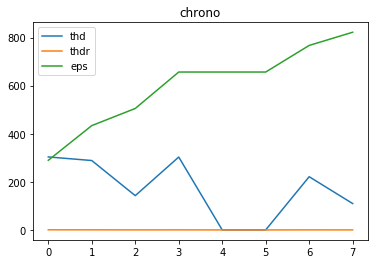

In [81]:
plot_thd_thdr(thd_list, thdr_list, eps_list, order)

In [1]:
plot_thd_thdr(thd_list, thdr_list, eps_list, order)

NameError: name 'plot_thd_thdr' is not defined

## Stage 6. Taxonomy generator

Performed for one random taken file from previously cleaned.

In [ ]:
start = timeit.default_timer()
dataset = dataset_genreator("random", 1, clean_txt_folder)
terms = term_extractor.extract_terms(dataset)#, verbose=False)
terms = tf(terms)

threshold_match = 0.9
threshold_combine = 0.6
to_merge = {}
to_combine = {}
for k in range(len(terms)):
    temp = terms.iloc[[k]]["term"]
    temp2 = terms.iloc[[k]]["term"].tolist()[0]
    term = str(terms.iloc[[k]]["term"].tolist()[0])
    merge_list = []
    combine_list = []
    for j in range(k+1,len(terms)):
        if jaro_sim(str(term), str(terms.iloc[[j]]["term"].tolist()[0])) > threshold_match:
            merge_list.append(str(terms.iloc[[j]]["term"].tolist()[0]))
            terms.drop(terms.index[j])
        elif jaro_sim(str(term), str(terms.iloc[[j]]["term"].tolist()[0])) > threshold_combine:
            combine_list.append(str(terms.iloc[[j]]["term"].tolist()[0]))
    if len(merge_list)>0:
        to_merge[term] = merge_list
    if len(combine_list) > 0:
        to_combine[term] = combine_list
stop = timeit.default_timer()
print("Elapsed time: {} s".format(stop-start))


All results are saved to output.txt folder.
##### Elapsed time: 174.118080098 s

### Sample output:
###### Please think about merging next terms as they are pretty similar
basic time units with ['basic time unit']

time unit with ['time units']

information systems with ['informatik systeme']

overall workow execution with ['overall workow duration']


###### Please think about combining somehow next terms
process management with ['process reengineering purposes', 'time management tries', 'process priorities']

time histogram with ['time violations', 'time problems', 'time property', 'time vi olations', 'time restrictions', 'time unit', 'time line', 'time model', 'time units', 'timely manner', 'timed graph', 'time interval', 'time value', 'time constraint violations', 'time management tries', 'time in workow systems', 'time management problems']

latest allowed end blae with ['latest allowed start time']

time interval with ['time value', 'valid time interval', 'time constraint violations', 'time management tries', 'time in workow systems', 'time management problems']

green orange with ['cepe ', 'green everything']